In [1]:
import sys
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd())

import trinity
from brownian import *

In [2]:
# We first generate the token price via GBM

s0 = [100,100,100]
mu = [0.1,0.1,0.1]
sig = [0.2,0.2,0.2]
cv = [[0.01,0.005,0.005],[0.005,0.04,0.02],[0.005,0.02,0.16]]
step = 252

Generator = Brownian(s0, mu, sig, cv, step)
s = Generator.generate()

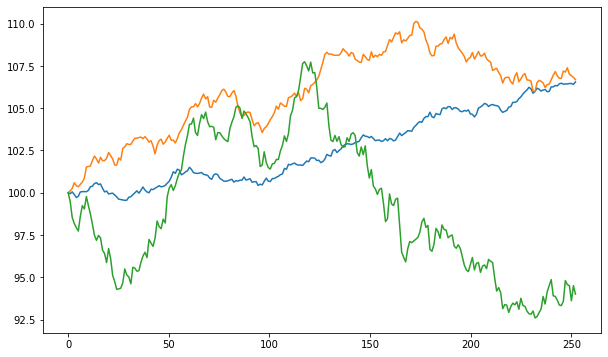

In [3]:
# Plot graph

x = np.linspace(0,step,step)
plt.figure(num = len(s0), figsize=(10, 6))
for i in range(len(s0)):
    plt.plot(x, s[i].flatten())
plt.show()

In [4]:
def run(s, print_ind = False):
    
    trinity.print_ind = print_ind
    
    # Create all system elements
    Trinity = trinity.pool()
    
    ETH = trinity.tokens('ETH')
    DAI = trinity.tokens('DAI')
    CRO = trinity.tokens('CRO')
    
    Peter = trinity.users("Peter") # Peter is the user
    Mary = trinity.users("Mary") # Mary is the arbitrageur
    Others = trinity.users("Others") # This is an external system (for book keeping of arbitrageur)
    
    # Set token's initial price
    ETH.price = s[0,0]
    DAI.price = s[0,1]
    CRO.price = s[0,2]

    Tokens = [ETH, DAI, CRO]
    m = len(Tokens)
    
    # Set the parameters for transaction counts (follow poisson(lambda))
    lambda_ETH_DAI = 1
    lambda_ETH_CRO = 1
    lambda_DAI_CRO = 1

    lambda_ = [lambda_ETH_DAI, lambda_ETH_CRO, lambda_DAI_CRO]

    # Set the parameters for transaction amount (follow normal(0, phi^2))
    phi_ETH_DAI = 10000
    phi_ETH_CRO = 10000
    phi_DAI_CRO = 10000

    phi_ = [phi_ETH_DAI, phi_ETH_CRO, phi_DAI_CRO]

    # Arbitrageur related parameters
    arb_threshold = 100 * 1.2
    arb_profit = 0
    unwind_ind = True

    # Create Users
    Peter.wallet = {"ETH": 200000, "DAI": 200000, "CRO": 200000}
    Mary.wallet = {"ETH": 200000, "DAI": 200000, "CRO": 200000}
    Others.wallet = {"ETH": 100000, "DAI": 100000, "CRO": 100000}
    
    Mary_init = copy.deepcopy(Mary.wallet)

    # Initial Deposit
    Peter.deposit(Trinity, ETH, 100000)
    Peter.deposit(Trinity, DAI, 100000)
    Peter.deposit(Trinity, CRO, 100000)

    for t in range(1,step):

        # Set the new price
        for token in range(m):
            Tokens[token].price = s[token,t]

        counter = 0
        for ft in range(m):
            for tt in range(ft+1, m):
                count = np.random.poisson(lambda_[counter])
                for c in range(count):
                    from_token = Tokens[ft]
                    to_token = Tokens[tt]

                    # User Actions
                    amount = np.random.normal(0, phi_[counter])
                    if amount > 0:
                        Peter.swap(Trinity, from_token, to_token, amount/from_token.price)
                    else:
                        Peter.swap(Trinity, to_token, from_token, -amount/to_token.price)

                    # Arbitrageur calculation
                    eqm, profit = trinity.arb_profit(from_token, to_token)

                    # Only do arbitrage if condition is fulfilled
                    # Note that the t == step - 1 is to remove any system surplus at the end for measuring true system equity
                    if profit > arb_threshold or t == step-1:
                        if from_token.cov_ratio() < eqm:
                            amount = from_token.liab()*(eqm-from_token.cov_ratio())
                            Mary.swap(Trinity, from_token, to_token, amount)
                        else:
                            amount = to_token.liab()*(eqm-to_token.cov_ratio())
                            Mary.swap(Trinity, to_token, from_token, amount)

                counter += 1

        if unwind_ind:
            # Unwind arbitrageur position
            for token in Tokens:
                arb_profit += (Mary.wallet[token.name] - Mary_init[token.name])*token.price
                Others.wallet[token.name] += Mary.wallet[token.name] - Mary_init[token.name]
                Mary.wallet[token.name] = Mary_init[token.name]
                
    System_Equity = (ETH.asset()-ETH.liab())*ETH.price + (DAI.asset()-DAI.liab())*DAI.price + (CRO.asset()-CRO.liab())*CRO.price
    System_Haircut = ETH.hf_sys*ETH.price + DAI.hf_sys*DAI.price + CRO.hf_sys*CRO.price
    System_FX = System_Equity - System_Haircut
    
    if print_ind:
        # Leakage Test
        # Note that starting ETH = 500,000, starting DAI = 500,000, starting CRO = 500,000

        init_state = {"ETH": 500000, "DAI": 500000, "CRO": 500000}

        print("---------")
        for token in trinity.tokens.get_instances():
            user_cash = 0
            for user in trinity.users.get_instances():
                user_cash += user.wallet[token.name]
            token_end_balance = token.cash + user_cash
            leakage = init_state[token.name] - token_end_balance
            print('{0} leakage is {1}'.format(token.name, leakage))
            
        for user in trinity.users.get_instances():
            print("---------")
            print(user.name, "Wallet", user.wallet)
            print(user.name, "LP_Token", user.lp_token)

        for token in trinity.tokens.get_instances():
            print("---------")
            print(token.name, "Assets", token.asset())
            print(token.name, "Liabilities", token.liab())
            print(token.name, "Cov_Ratio", token.cov_ratio())
            print(token.name, "Quk_Ratio", token.quk_ratio())
            print(token.name, "LP_ROI", str(round((token.deposit/token.lp_tokens - 1)*100,4))+ "%")
            
        print("---------")
        print("Equity for System: " + str(System_Equity))
        print("Haircut for System: " + str(System_Haircut))
        print("FX Gain / Loss for system: " + str(System_FX))
        print("Arbitrageur Profit: " + str(arb_profit))
    
    return [System_Haircut, System_FX, arb_profit]

In [5]:
run(s, True)

Sucessfully deposited 100000 ETH from Pool for Peter
Sucessfully deposited 100000 DAI from Pool for Peter
Sucessfully deposited 100000 CRO from Pool for Peter
Sucessfully swapped 167.74177786810026 DAI from 168.49390335509173 ETH for Peter. Fees charged: 0.4035166882342902
Sucessfully swapped 40.90406656264789 CRO from 40.33650011933502 ETH for Peter. Fees charged: 0.05492533671932862
Sucessfully swapped 13.303332964251394 ETH from 13.514465279802613 CRO for Peter. Fees charged: 0.005740455105121076
Sucessfully swapped 125.59080660987307 CRO from 123.99260649780159 ETH for Peter. Fees charged: 0.31531192048710366
Sucessfully swapped 32.366375889922985 DAI from 32.72321017718521 ETH for Peter. Fees charged: 0.1320739701927396
Sucessfully swapped 57.5883333209937 DAI from 59.15930354671486 CRO for Peter. Fees charged: 0.15927009449129276
Sucessfully swapped 21.846423728323213 DAI from 22.1202554291136 ETH for Peter. Fees charged: 0.120253847702579
Sucessfully swapped 51.810983435771746 C

[6433.950571958194, 80.9282452136631, 4457.86659849338]

---------
Peter Wallet {'ETH': 101341.14608859784, 'DAI': 101956.16151602555, 'CRO': 96266.16277279469}
Peter LP_Token {'ETH': 100000, 'DAI': 100000, 'CRO': 100000}
---------
Mary Wallet {'ETH': 200000, 'DAI': 200000, 'CRO': 200000}
Mary LP_Token {}
---------
Others Wallet {'ETH': 98372.55642488014, 'DAI': 98180.42032581373, 'CRO': 103816.93332787885}
Others LP_Token {}
---------
ETH Assets 100286.29748652203
ETH Liabilities 100005.32178296449
ETH Cov_Ratio 1.0028096075143613
ETH Quk_Ratio 1.0028096075143613
ETH LP_ROI 0.0053%
---------
DAI Assets 99863.4181581607
DAI Liabilities 100004.99848860664
DAI Cov_Ratio 0.9985842674607702
DAI Quk_Ratio 0.9985842674607702
DAI LP_ROI 0.005%
---------
CRO Assets 99916.90389932643
CRO Liabilities 100005.40561274235
CRO Cov_Ratio 0.9991150307038538
CRO Quk_Ratio 0.9991150307038538
CRO LP_ROI 0.0054%
---------
Equity for System: 6514.878817171857
Haircut for System: 6433.950571958194
FX Gain / Loss for system: 80.9282452136631
Arbitrageur Profit: 44

In [6]:
sim_result = []
for sim in range(1000):
    sim_result.append(run(Generator.generate(), False))

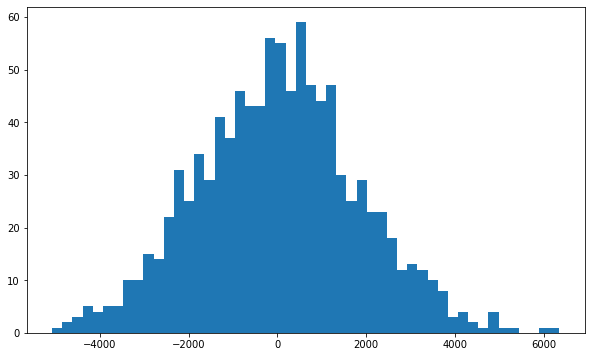

In [7]:
data = np.transpose(np.array(sim_result))

plt.figure(figsize=(10,6))
plt.hist(data[1], bins = 50)
plt.show()

In [14]:
# Simulation Result
VaR = np.quantile(data[1], 0.01)
mean_haircut = np.average(data[0])
mean_arb_profit = np.average(data[2])

print("VaR for System: " + str(VaR))
print("Haircut for System: " + str(mean_haircut))
print("Arbitrageur Profit: " + str(mean_arb_profit))

VaR for System: -4167.941829223741
Haircut for System: 6299.873933809578
Arbitrageur Profit: 4431.1995698009205
